# Compare Kr selections for two runs

J.A Hernando
22/01/19

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Thu Jan 24 10:53:54 2019


### Configuration

In [2]:
run_number_ref   = 6484
run_number_test  = 6803

input_dst_filename_ref   = f"$IC_DATA/{run_number_ref}/kdsts/kdst_{run_number_ref}_filtered.h5"
input_dst_filename_test  = f"$IC_DATA/{run_number_test}/kdsts/kdst_{run_number_test}_filtered.h5"

### Imports

In [3]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf

from invisible_cities.core .core_functions import in_range

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.utils.hst_extend_functions as hst
import krcal.utils.plt_functions        as apt
import krcal.utils.kdst_functions       as kdstf
import krcal.dev.akr_functions          as akr
import krcal.dev.corrections            as corrections

In [4]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [5]:
_input_dst = os.path.expandvars(input_dst_filename_ref)
print(_input_dst)
dst_ref    = kdstf.load_dsts([_input_dst, ], "DST", "Events")

_input_dst = os.path.expandvars(input_dst_filename_test)
print(_input_dst)
dst_test   = kdstf.load_dsts([_input_dst, ], "DST", "Events")

dsts = [dst_ref, dst_test]

/Users/hernando/investigacion/NEXT/data/runIV//6484/kdsts/kdst_6484_filtered.h5
/Users/hernando/investigacion/NEXT/data/runIV//6803/kdsts/kdst_6803_filtered.h5


In [6]:
seconds_ref  = (dst_ref .time.max() - dst_ref .time.min()) 
seconds_test = (dst_test.time.max() - dst_test.time.min()) 

print('seconds', seconds_ref, seconds_test)

weight_ref  = 1./seconds_ref
weight_test = 1./seconds_test

weights = [weight_ref, weight_test]

seconds 87557.55599999428 123593.10500001907


In [7]:
dst_ref.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [9]:
dst_test['dtime'] = dst_test.time.values - dst_test.time.values.min()
dst_ref ['dtime'] = dst_ref .time.values - dst_ref .time.values.min()

In [10]:
def slabel(mean, rms, sformat="{0:2.1f}"):
    s =  'mean:'+ sformat.format(mean)+ ', '
    s += 'rms :'+ sformat.format(rms)
    return s

def hist(varname, varaxis, dst, weight):
    var = dst[varname].values
    v0, v1 = varaxis.range
    sel = in_range(var, v0, v1)
    xvar = var[sel]
    mean, rms = np.mean(xvar), np.std(xvar)
    weights = np.ones(len(xvar))*weight
    ycon, xedg, _ = plt.hist(xvar, varaxis.bins, weights = weights, label = slabel(mean, rms), alpha = 0.5);
    plt.xlabel(varname)
    plt.ylabel('rate (Hz)')
    plt.legend()
    return ycon, xedg
    

def hist_comp(varname, varaxis, dsts, weights):
    c = hst.Canvas(1, 2)
    c(1)
    y1, x1 = hist(varname, varaxis, dsts[0], weights[0])
    y2, x2 = hist(varname, varaxis, dsts[1], weights[1])
    
    sel = y2 > 0
    rat = np.zeros(len(y1))
    rat[sel] = y2[sel]/y1[sel]
    c(2)
    xx = 0.5*(x1[1:] + x1[:-1])
    plt.plot(xx, rat, '*')
    plt.xlabel(varname)
    plt.ylabel('ratio')
    ylim = min(2., max(rat)+0.1)
    plt.ylim((0., ylim))
    plt.tight_layout()
    #plt.legend()
    return


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


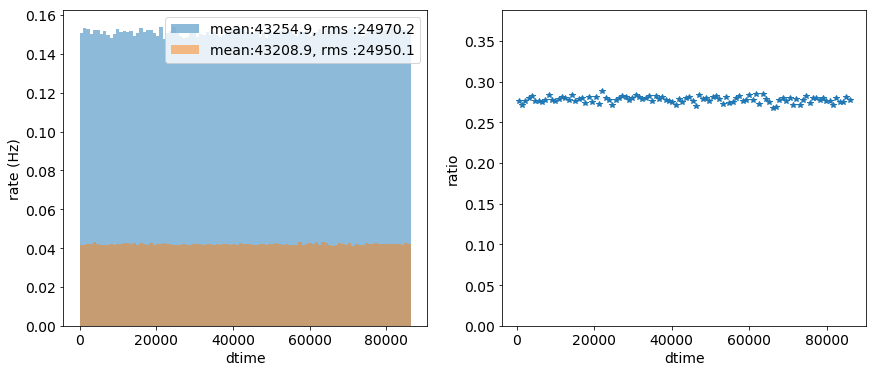

In [11]:
dtaxis = hst.Vaxis((-10., 24.*3600), 100)
hist_comp('dtime', dtaxis, dsts, weights)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


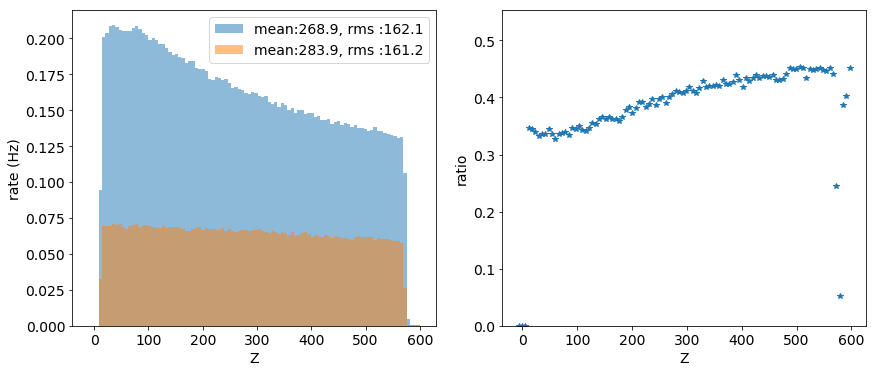

In [9]:
zaxis = hst.Vaxis((-10., 600.), 100)
hist_comp('Z', zaxis, dsts, weights)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


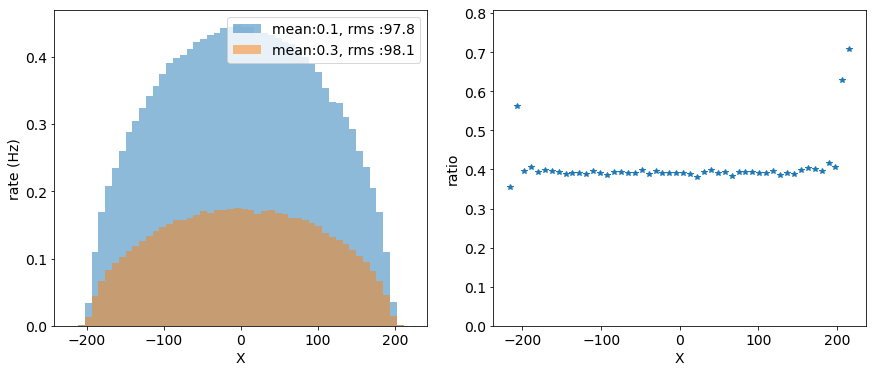

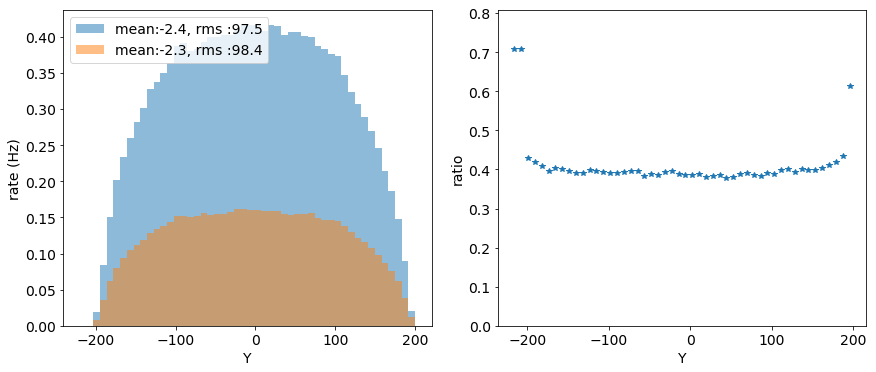

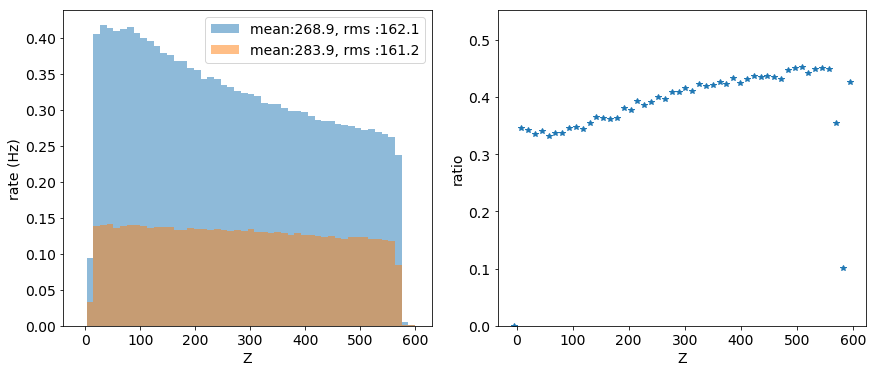

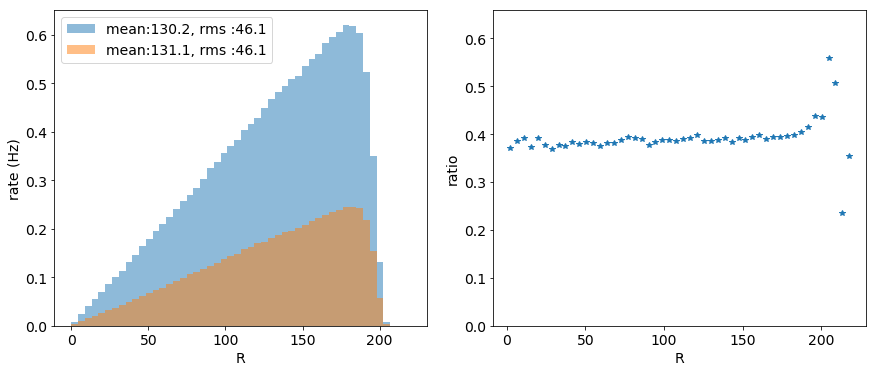

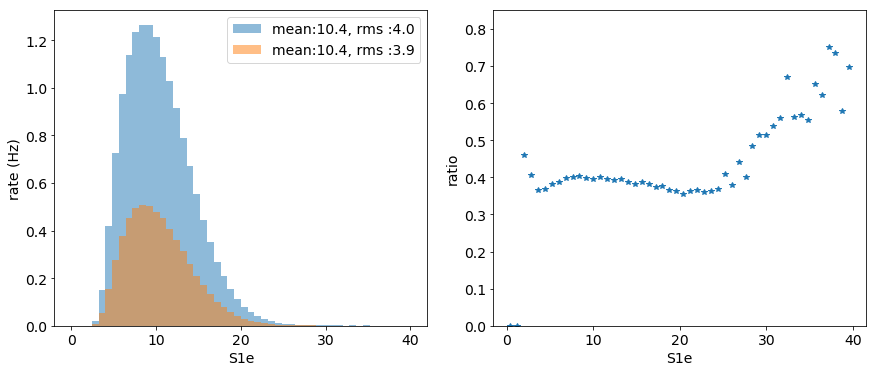

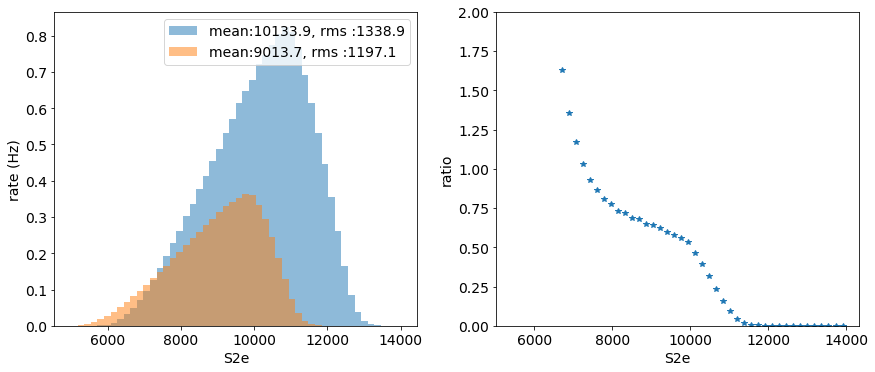

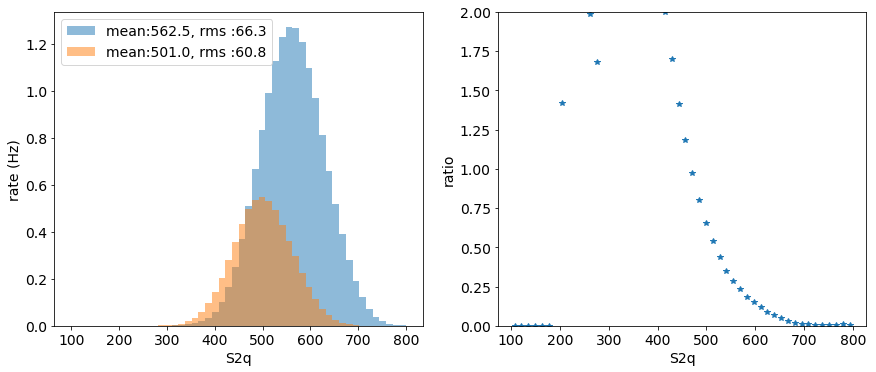

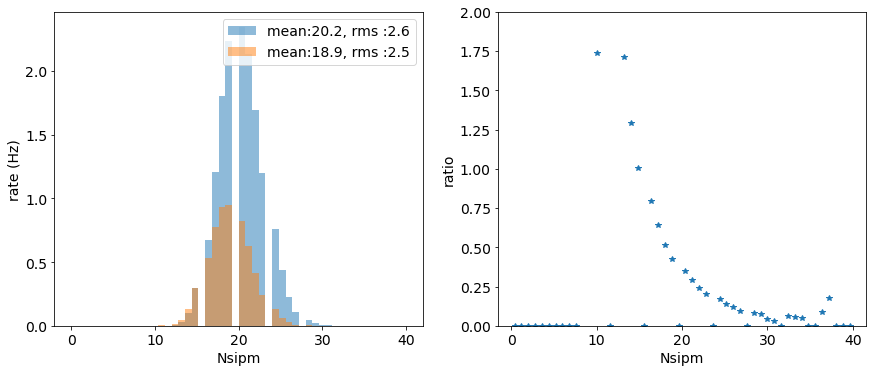

In [10]:
vd = {}
vd['X']   = -220., 220.
vd['Y']   = -220., 200.
vd['Z']   =  -10., 600.
vd['R']   =   -0., 220.

vd['S1e'] =    0., 40.
vd['S2e'] =  5.e3, 14.e3
vd['S2q'] =  1.e2, 8.e2
vd['Nsipm'] = 0., 40


for key in vd.keys():
    axis = hst.Vaxis(vd[key], 50)
    hist_comp(key, axis, dsts, weights)